In [1]:
# Hack to import from a parent directory
import sys
path = '..'
if path not in sys.path:
    sys.path.append(path)

In [2]:
#Python-related imports
import math, sys
from typing import Dict, Tuple, Union
from datetime import datetime
import os.path

#Torch-related imports
import torch
from torch.autograd import Function
from torch import nn
import torch.distributions as D
import torch.nn.functional as F
import torch.optim as optim

#Module imports
from SBM_SDE_classes_optim import *
from obs_and_flow import *
from training import *
from plotting import *
from mean_field import *
from TruncatedNormal import *
from LogitNormal import *

In [3]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import time
from scipy.optimize import bisect

## Load data

In [51]:
save_dir = 'data/dt_01_t_100000_minibatch_logit_theta_trunc_trans/SCON_C_{}.pt'
target_hyperparams_file = save_dir.format('target_hyperparams')
hyperparams_file = save_dir.format('hyperparams')
theta_file = save_dir.format('theta')
x_file = save_dir.format('x')
x0_dist_file = save_dir.format('x0_dist')
y_dict_file = save_dir.format('y_dict')

target_hyperparams = torch.load(target_hyperparams_file)
theta_hyperparams = torch.load(hyperparams_file)
theta_samples = torch.load(theta_file)
x = torch.load(x_file)
p_x0 = torch.load(x0_dist_file)
y_dict = torch.load(y_dict_file)

In [5]:
theta_hyperparams, theta_samples

({'u_M': tensor([-6.4362,  0.3104,  0.0000,  1.0000]),
  'a_SD': tensor([0.0000, 0.7465, 0.0000, 1.0000]),
  'a_DS': tensor([0.0000, 0.7465, 0.0000, 1.0000]),
  'a_M': tensor([0.0000, 0.7465, 0.0000, 1.0000]),
  'a_MSC': tensor([0.0000, 0.7465, 0.0000, 1.0000]),
  'k_S_ref': tensor([-7.6004,  0.3100,  0.0000,  1.0000]),
  'k_D_ref': tensor([-7.1301,  0.3101,  0.0000,  1.0000]),
  'k_M_ref': tensor([-7.2637,  0.3101,  0.0000,  1.0000]),
  'Ea_S': tensor([  0.0000,   0.9685,  10.0000, 100.0000]),
  'Ea_D': tensor([ -0.3137,   0.8252,  10.0000, 100.0000]),
  'Ea_M': tensor([ -0.3137,   0.8252,  10.0000, 100.0000]),
  'c_SOC': tensor([0.0000, 0.7465, 0.0000, 1.0000]),
  'c_DOC': tensor([-4.5951,  0.3137,  0.0000,  1.0000]),
  'c_MBC': tensor([-4.5951,  0.3137,  0.0000,  1.0000])},
 {'u_M': tensor(0.0026),
  'a_SD': tensor(0.4455),
  'a_DS': tensor(0.1643),
  'a_M': tensor(0.6045),
  'a_MSC': tensor(0.3080),
  'k_S_ref': tensor(0.0003),
  'k_D_ref': tensor(0.0009),
  'k_M_ref': tensor(0.000

In [52]:
target_hyperparams

{'u_M': tensor([1.59999996e-03, 5.32799982e-04, 0.00000000e+00, 1.00000000e+00]),
 'a_SD': tensor([0.50000000, 0.16650000, 0.00000000, 1.00000000]),
 'a_DS': tensor([0.50000000, 0.16650000, 0.00000000, 1.00000000]),
 'a_M': tensor([0.50000000, 0.16650000, 0.00000000, 1.00000000]),
 'a_MSC': tensor([0.50000000, 0.16650000, 0.00000000, 1.00000000]),
 'k_S_ref': tensor([5.00000024e-04, 1.66500002e-04, 0.00000000e+00, 1.00000000e+00]),
 'k_D_ref': tensor([7.99999980e-04, 2.66399991e-04, 0.00000000e+00, 1.00000000e+00]),
 'k_M_ref': tensor([6.99999975e-04, 2.33100000e-04, 0.00000000e+00, 1.00000000e+00]),
 'Ea_S': tensor([ 55.00000000,  18.31500053,  10.00000000, 100.00000000]),
 'Ea_D': tensor([ 48.00000000,  15.98400021,  10.00000000, 100.00000000]),
 'Ea_M': tensor([ 48.00000000,  15.98400021,  10.00000000, 100.00000000]),
 'c_SOC': tensor([0.50000000, 0.16650000, 0.00000000, 1.00000000]),
 'c_DOC': tensor([0.01000000, 0.00333000, 0.00000000, 1.00000000]),
 'c_MBC': tensor([0.01000000, 0

In [70]:
x.shape

torch.Size([1, 1000001, 3])

## Inference

Let $x$ be the observed states (i.e. SOC, DOC, and MBC in the SCON-SS model) and $\theta$ be the model parameters. The generative model is:
- $\theta \sim \text{LogitNormal}(\mu_\theta, \sigma_\theta, a, b)$
- $x_1 \sim p(x_1|\theta)$
- For $i=2, ..., T$: $x_i \sim p(x_i|x_{i-1}, \theta)$

We use variational posterior $q_\phi(\theta)=\text{MultivariateLogitNormal}(\hat{\mu}, \hat{L}\hat{L}^T, a, b)$ with variational parameter $\phi=(\hat{\mu}, \hat{L})$. For minibatching, we partition the sequence $x$ into $B$ consecutive subsequences $x_b$. We sample a minibatch by drawing $b$ uniformly from $1, ..., B$. Let $u_b$ and $v_b$ denote the endpoints of the $b$th subsequence, $x_b = x_{u_b:v_b}$. The minibatch loss is:
$$
\mathcal{L} = E_{q_\phi(\theta)}\left[ \log p(\theta) - \log q(\theta) + \log p(x_b|\theta) \right] \\
$$

where the log likelihood term is given by:
$$
\log p(x_b|\theta) = \sum_{i=u_b}^{v_b} \log p(x_i|x_{i-1}, \theta)
$$
if $u_b > 1$, otherwise: $\log p(x_b|\theta) = \log p(x_1|\theta) + \sum_{i=u_b+1}^{v_b} \log p(x_i|x_{i-1}, \theta)$.

Reparameterized gradient wrt variational parameter $\phi$:
$$
\nabla_\phi \mathcal{L} \approx -\frac{1}{S} \sum_s \nabla_\phi \left[
    \log p(g_\phi(\epsilon^{(s)})) + \log p(x_b|g_\phi(\epsilon^{(s)})) - \log q(g_\phi(\epsilon^{(s)}))
    \right]
$$

where $\epsilon^{(s)} \sim \text{MultivariateNormal}(0, I)$ and $g_\phi(\epsilon)=(b-a) \odot \sigma(\hat{\mu}+\hat{L}\epsilon)+a$, with $\odot$ to denote elementwise multiplication.

Pseudocode:
- for each iteration $n=1, ..., N$:
  - Sample minibatch: $b \sim \text{Uniform}(1, ..., B)$
  - Sample $\theta$: $\theta^{(s)} \sim q(\theta)$ for $s=1, ..., S$
  - `loss` $= -\frac{1}{S} \sum_s \left[\log p(\theta^{(s)}) + \log p(x_b|\theta^{(s)}) - \log q(\theta^{(s)})\right]$ 
  - `loss.backward()`

**Implementation note:** The covariance matrix $\Sigma$ of the multivariate normal in PyTorch is parameterized in terms of a lower-triangular matrix $L$ with positive-valued diagonal entries, such that $\Sigma = LL^T$. In practice, we optimize the unconstrained transformation of $L$. The following code shows how the mapping is done back and forth:
```
def to_constrained(self, x):
    # Takes unconstrained square matrix x and returns L, s.t. Sigma = LL^T
    return x.tril(-1) + x.diagonal(dim1=-2, dim2=-1).exp().diag_embed()

def to_unconstrained(self, y):
    return y.tril(-1) + y.diagonal(dim1=-2, dim2=-1).log().diag_embed()
```

In [24]:
t = int(y_dict['t_x'][-1])
dt_flow = 1.0 # [1.0, 0.5]
temp_ref = 283
temp_rise = 5 #High estimate of 5 celsius temperature rise by 2100.

In [25]:
active_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.set_printoptions(precision = 8)

#Neural SDE parameters
n = int(t / dt_flow) + 1
t_span = np.linspace(0, t, n)
t_span_tensor = torch.reshape(torch.Tensor(t_span), [1, n, 1]).to(active_device) #T_span needs to be converted to tensor object. Additionally, facilitates conversion of I_S and I_D to tensor objects.

#Specify desired SBM SDE model type and details.
SBM_SDE_class = 'SCON'
diffusion_type = 'C'
theta_dist = 'RescaledLogitNormal' #String needs to be exact name of the distribution class. Other option is 'RescaledLogitNormal'.
theta_post_dist = 'MultivariateLogitNormal'

#Generate exogenous input vectors.
#Obtain temperature forcing function.
temp_tensor = temp_gen(t_span_tensor, temp_ref, temp_rise).to(active_device)

#Obtain SOC and DOC pool litter input vectors for use in flow SDE functions.
i_s_tensor = i_s(t_span_tensor).to(active_device) #Exogenous SOC input function
i_d_tensor = i_d(t_span_tensor).to(active_device) #Exogenous DOC input function

In [29]:
def calc_log_lik(C_PATH, PARAMS_DICT, DT, SBM_SDE_CLASS, INIT_PRIOR, start_idx, end_idx, calc_full=False):      
    # Compute drift and diffusion
    if calc_full:
        drift, diffusion_sqrt = SBM_SDE_CLASS.drift_diffusion(C_PATH, PARAMS_DICT, diffusion_matrix=False)
        #p_x = D.multivariate_normal.MultivariateNormal(loc = C_PATH[:, :-1, :] + drift * DT,
        #                                               scale_tril = diffusion_sqrt * math.sqrt(DT)) 
        p_x = TruncatedNormal(loc = C_PATH[:, :-1, :] + drift * DT,
                              scale = diffusion_sqrt * math.sqrt(DT), a = 0, b = 1000)
    
        # Compute log p(x|theta) = log p(x|x0, theta) + log p(x0|theta)
        log_p_x = p_x.log_prob(C_PATH[:, 1:, :]).sum(-1) # log p(x_i|x_{i-1}, theta), (batch_size, N - 1)
        log_p_x0 = INIT_PRIOR.log_prob(C_PATH[:, 0, :]).sum(-1) # log p(x0|theta), (batch_size, )
        ll_minibatch = log_p_x[:, start_idx:end_idx-1].sum(-1) # (batch_size, )
        if start_idx == 0:
            ll_minibatch += log_p_x0
        ll_full = log_p_x.sum(-1) + log_p_x0 # log p(x|theta), (batch_size, )
    
    else:
        drift, diffusion_sqrt = SBM_SDE_CLASS.drift_diffusion(C_PATH[:, start_idx:end_idx-1, :], PARAMS_DICT, start_idx, end_idx, diffusion_matrix=False) 
        p_x = TruncatedNormal(loc = C_PATH[:, start_idx:end_idx-1, :] + drift * DT,
                              scale = diffusion_sqrt * math.sqrt(DT), a = 0, b = 1000)
    
        # Compute log p(x|theta) = log p(x|x0, theta) + log p(x0|theta)
        ll_minibatch = p_x.log_prob(C_PATH[:, start_idx+1:end_idx, :]).sum((-2, -1)) # log p(x|x0, theta), (batch_size, )
        if start_idx == 0:
            ll_minibatch += INIT_PRIOR.log_prob(C_PATH[:, 0, :]).sum(-1) # log p(x0|theta), (batch_size, )
        ll_full = None
    
    return ll_minibatch, ll_full

def train(DEVICE, LR, NITER, BATCH_SIZE, MINIBATCH_SIZE, X_ALL, T, DT, N,
          T_SPAN_TENSOR, I_S_TENSOR, I_D_TENSOR, TEMP_TENSOR, TEMP_REF,
          SBM_SDE_CLASS, DIFFUSION_TYPE, X0_PRIOR, PRIOR_DIST_DETAILS_DICT, 
          THETA_DIST = None, THETA_POST_DIST = None, THETA_POST_INIT = None,
          LR_DECAY = 0.8, DECAY_STEP_SIZE = 50000, PRINT_EVERY = 100, MINIBATCH_INDICES=None,
          CALC_LOSS_EVERY=100):
    torch.manual_seed(seed)
    
    # Instantiate SBM_SDE object based on specified model and diffusion type.
    SBM_SDE_class_dict = {
            'SCON': SCON_optim,
            'SAWB': SAWB_optim,
            'SAWB-ECA': SAWB_ECA_optim
            }
    if SBM_SDE_CLASS not in SBM_SDE_class_dict:
        raise NotImplementedError('Other SBM SDEs aside from SCON, SAWB, and SAWB-ECA have not been implemented yet.')
    SBM_SDE_class = SBM_SDE_class_dict[SBM_SDE_CLASS]
    SBM_SDE = SBM_SDE_class(T_SPAN_TENSOR, I_S_TENSOR, I_D_TENSOR, TEMP_TENSOR, TEMP_REF, DIFFUSION_TYPE)

    # If dt_flow > dt, we need to throw away additional points from x,
    # then add a leading dimension since SBM_SDE_classes assumes that first dim is batch size
    # x.shape: (N_gen, state_dim) -> (1, N_flow, state_dim)
    step = (X_ALL.shape[0] - 1) // (N - 1)
    x = X_ALL[::step, :SBM_SDE.state_dim].unsqueeze(0)
    assert x.shape == (1, N, SBM_SDE.state_dim)

    # Convert prior details dictionary values to tensors.
    param_names = list(PRIOR_DIST_DETAILS_DICT.keys())
    prior_list = list(zip(*(PRIOR_DIST_DETAILS_DICT[k] for k in param_names))) #Unzip prior distribution details from dictionary values into individual lists.
    prior_means_tensor, prior_sds_tensor, prior_lowers_tensor, prior_uppers_tensor = torch.tensor(prior_list).to(DEVICE) #Ensure conversion of lists into tensors.

    # Retrieve desired distribution class based on string.
    dist_class_dict = {
            'TruncatedNormal': TruncatedNormal,
            'RescaledLogitNormal': RescaledLogitNormal,
            'MultivariateLogitNormal': MultivariateLogitNormal
            }
    THETA_PRIOR_CLASS = dist_class_dict[THETA_DIST]
    THETA_POST_CLASS = dist_class_dict[THETA_POST_DIST] if THETA_POST_DIST else dist_class_dict[THETA_DIST]
    
    # Define prior
    p_theta = THETA_PRIOR_CLASS(loc = prior_means_tensor, scale = prior_sds_tensor, a = prior_lowers_tensor, b = prior_uppers_tensor)

    # Initialize posterior q(theta) using its prior p(theta)
    learn_cov = (THETA_POST_DIST == 'MultivariateLogitNormal')
    if THETA_POST_INIT is None:
        THETA_POST_INIT = PRIOR_DIST_DETAILS_DICT
    q_theta = MeanField(DEVICE, param_names, THETA_POST_INIT, THETA_POST_CLASS, learn_cov)

    #Record loss throughout training (needs moving average bc of minibatching)
    #best_loss = 1e15
    losses = []
    losses_full = []
    times = []

    #Initiate optimizers.
    optimizer = optim.Adamax(list(q_theta.parameters()), lr = LR)
    
    # Sample minibatch endpoints
    if MINIBATCH_SIZE < N:
        if MINIBATCH_INDICES is None:
            step = (N - MINIBATCH_SIZE) // NITER
            MINIBATCH_INDICES = torch.arange(0, (N - MINIBATCH_SIZE), step)
        rand = torch.randint(len(MINIBATCH_INDICES), (NITER, ))
        print(torch.min(torch.bincount(rand)))
        batch_indices = MINIBATCH_INDICES[rand]
    
    #Training loop
    t0 = time.time()
    with tqdm(total = NITER, desc = f'Learning SDE and hidden parameters.', position = -1) as tq:
        for it in range(1, NITER + 1):
            optimizer.zero_grad()    
            
            # Sample theta ~ q(theta) and compute log q(theta)
            theta_dict, theta, log_q_theta, _ = q_theta(BATCH_SIZE)
            
            # Compute log p(theta)
            log_p_theta = p_theta.log_prob(theta).sum(-1)

            # Compute log p(x_{u-1:v}|theta) (unless u = 0, then x_{u:v})
            if MINIBATCH_SIZE < N:
                start_idx = max(0, batch_indices[it-1] - 1)              # u-1 if u > 0, else 0
                end_idx = min(N, batch_indices[it-1] + MINIBATCH_SIZE)   # v
            else:
                start_idx, end_idx = 0, N
            #print(batch_id, start_idx, end_idx)
            calc_loss = (it % CALC_LOSS_EVERY == 0) or (it == 1)
            ll, ll_full = calc_log_lik(x, theta_dict, DT, SBM_SDE, X0_PRIOR,
                                       start_idx, end_idx, calc_loss)

            # Compute negative ELBO: -(log p(theta) + log p(x|theta) - log q(theta))
            loss = -log_p_theta.mean() - N/MINIBATCH_SIZE * ll.mean() + log_q_theta.mean()
            losses.append(loss.item())
            if calc_loss:
                loss_full = -log_p_theta.mean() - ll_full.mean() + log_q_theta.mean()
                losses_full.append(loss_full.item())

            # Take a gradient step
            loss.backward()
            torch.nn.utils.clip_grad_norm_(q_theta.parameters(), 5.0)
            optimizer.step()
            
            # Record time
            times.append(time.time() - t0)
            
            if it % PRINT_EVERY == 0:
                if calc_loss:
                    print('Iteration {} loss: {}'.format(it, loss_full))
                else:
                    k = 1000
                    ma_loss = losses[it-k-1:it-1].mean()
                    print('Iteration {} moving average loss: {}'.format(it, ma_loss))
        
            if it % DECAY_STEP_SIZE == 0:
                optimizer.param_groups[0]['lr'] *= LR_DECAY

            tq.update()
    
    return q_theta, p_theta, losses, losses_full, times

In [30]:
#Training parameters
niter = 200000 # niter = epochs * (n - 1) / minibatch_size
train_lr = 0.01 #ELBO learning rate
batch_size = 40 #3 - number needed to fit UCI HPC3 RAM requirements with 16 GB RAM at t = 5000.
minibatch_size = 1000
minibatch_indices = torch.arange(0, t + 1 - minibatch_size, minibatch_size) + 1
seed = 0

In [31]:
#Call training loop function for SCON-C.
t0 = time.time()
q_theta_raw, p_theta, losses_noisy, losses, times = train(
        active_device, train_lr, niter, batch_size, minibatch_size, x, t, dt_flow, n, 
        t_span_tensor, i_s_tensor, i_d_tensor, temp_tensor, temp_ref,
        SBM_SDE_class, diffusion_type, p_x0, theta_hyperparams,
        THETA_DIST=theta_dist, THETA_POST_DIST = theta_post_dist,
        LR_DECAY = 1.0, PRINT_EVERY = max(1, niter // 10), MINIBATCH_INDICES=minibatch_indices)
print(time.time() - t0)

torch.Size([1, 100001, 3])
tensor(1900)


Iteration 20000 loss: -65467.12109375
Iteration 40000 loss: -65448.9765625
Iteration 60000 loss: -65467.40234375
Iteration 80000 loss: -65460.8359375
Iteration 100000 loss: -65468.36328125
Iteration 120000 loss: -65461.78515625
Iteration 140000 loss: -65468.60546875
Iteration 160000 loss: -65468.73828125
Iteration 180000 loss: -65418.4765625
Iteration 200000 loss: -65469.94921875

8360.731077194214


In [32]:
#Call training loop function for SCON-C.
t0 = time.time()
q_theta_raw_mf, p_theta_mf, losses_noisy_mf, losses_mf, times_mf = train(
        active_device, train_lr, niter, batch_size, minibatch_size, x, t, dt_flow, n, 
        t_span_tensor, i_s_tensor, i_d_tensor, temp_tensor, temp_ref,
        SBM_SDE_class, diffusion_type, p_x0, theta_hyperparams, THETA_DIST=theta_dist, 
        LR_DECAY = 1.0, PRINT_EVERY = max(1, niter // 10), MINIBATCH_INDICES=minibatch_indices)
print(time.time() - t0)

torch.Size([1, 100001, 3])
tensor(1900)


Iteration 20000 loss: -65462.125
Iteration 40000 loss: -65457.8046875
Iteration 60000 loss: -65465.22265625
Iteration 80000 loss: -65462.421875
Iteration 100000 loss: -65466.83984375
Iteration 120000 loss: -65460.63671875
Iteration 140000 loss: -65468.89453125
Iteration 160000 loss: -65466.0703125
Iteration 180000 loss: -65412.65234375
Iteration 200000 loss: -65467.94140625

8651.729402780533


In [55]:
#Call training loop function for SCON-C.
t0 = time.time()
q_theta_raw_trunc_mf, p_theta_trunc_mf, losses_noisy_trunc_mf, losses_trunc_mf, times_trunc_mf = train(
        active_device, 1e-4, niter, batch_size, minibatch_size, x, t, dt_flow, n, 
        t_span_tensor, i_s_tensor, i_d_tensor, temp_tensor, temp_ref,
        SBM_SDE_class, diffusion_type, p_x0, theta_hyperparams,
        THETA_DIST=theta_dist, THETA_POST_DIST='TruncatedNormal', THETA_POST_INIT=target_hyperparams,
        LR_DECAY = 1.0, PRINT_EVERY = max(1, niter // 10), MINIBATCH_INDICES=minibatch_indices)
print(time.time() - t0)

torch.Size([1, 100001, 3])
tensor(1900)


Iteration 20000 loss: -65380.09375
Iteration 40000 loss: -65363.37109375
Iteration 60000 loss: -65411.75390625
Iteration 80000 loss: -65400.1640625
Iteration 100000 loss: -65416.37109375
Iteration 120000 loss: -65395.296875
Iteration 140000 loss: -65352.4921875
Iteration 160000 loss: -65403.8203125
Iteration 180000 loss: -65387.26171875
Iteration 200000 loss: -65399.140625

9261.129578113556


## Visualizations

In [33]:
def plot_loss(loss_hist_list, labels, xscale='linear', ymin=None, ymax=None,
              colors=None, linestyles=None, xvals=None, xlabel='iteration'):
    plt.rcParams.update({'font.size': 12, 'lines.linewidth': 2, 'figure.figsize': (8, 6)})
    if colors is None:
        colors = [cm.tab10(i+1) for i in range(len(labels))]
    if linestyles is None:
        linestyles = ['-'] * len(labels)
    if xvals is None:
        xvals = [None] * len(labels)
    
    for loss_hist, x, label, c, s in zip(loss_hist_list, xvals, labels, colors, linestyles):
        if x is None:
            plt.plot(loss_hist, label=label, color=c, linestyle=s)
        else:
            plt.plot(x, loss_hist, label=label, color=c, linestyle=s)
    
    plt.xlabel(xlabel)
    #plt.title('Loss v iteration')
    plt.ylabel('loss')
    plt.legend()
    plt.xscale(xscale)
    plt.ylim((ymin, ymax))

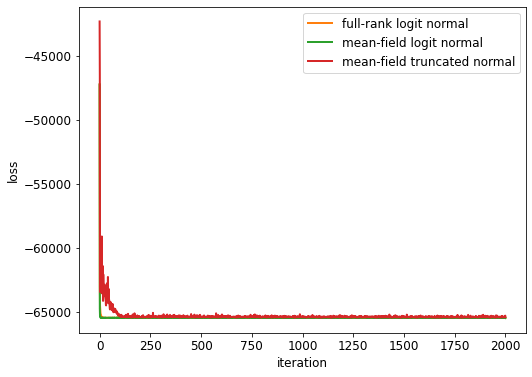

In [56]:
labels = ['full-rank logit normal', 'mean-field logit normal', 'mean-field truncated normal']
plot_loss([losses, losses_mf, losses_trunc_mf], labels, ymax=None, ymin=None)

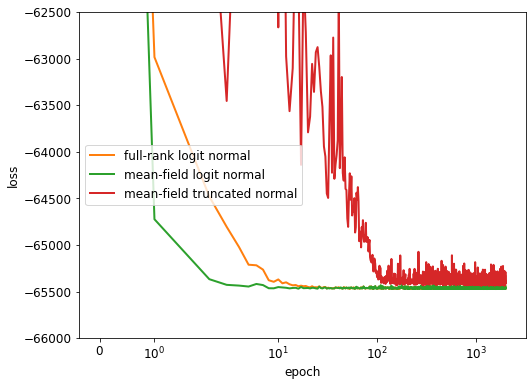

In [58]:
# epoch = iter * minibatch_size / (n - 1)
epochs = [torch.arange(0, niter + 1, 100) * minibatch_size / (n - 1)] * 3
plot_loss([losses, losses_mf, losses_trunc_mf], labels, ymax=-62500, ymin=-66000, xvals=epochs, xlabel='epoch', xscale='symlog')

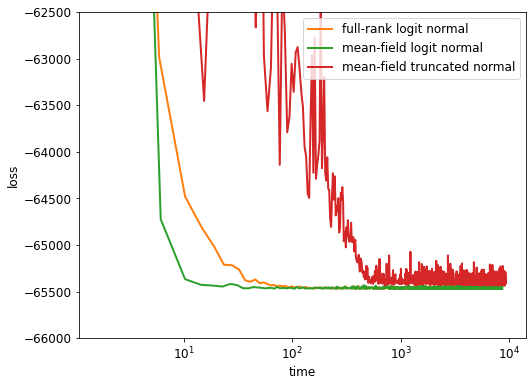

In [64]:
time_indices = torch.cat((torch.tensor([0]), torch.arange(99, niter + 1, 100)))
time_vals = [torch.tensor(times)[time_indices], torch.tensor(times_mf)[time_indices], torch.tensor(times_trunc_mf)[time_indices]]
plot_loss([losses, losses_mf, losses_trunc_mf], labels, ymax=-62500, ymin=-66000, xvals=time_vals, xlabel='time', xscale='symlog')

In [ ]:
labels = ['full-rank (full sequence)', 'mean-field (full sequence)',
          'full-rank (minibatch size = 5,000)', 'mean-field (minibatch size = 5,000)',
          'full-rank (minibatch size = 1,000)', 'mean-field (minibatch size = 1,000)']
colors =  [cm.tab10(i) for i in [1, 2, 1, 2, 1, 2]]
linestyles = ['-', '-', '--', '--', ':', ':']

epochs = [None] * 2 + \
         [torch.arange(0, niter + 1, 100) * size5k / (n - 1)] * 2 + \
         [torch.arange(0, niter + 1, 100) * size1k / (n - 1)] * 2
plot_loss([losses_full, losses_mf_full, losses_mini5k, losses_mf_mini5k, losses_mini1k, losses_mf_mini1k],
          labels, ymax=-61000, ymin=-62200, 
          colors=colors, linestyles=linestyles, xvals=epochs, xscale='symlog', xlabel='epoch')

In [ ]:
time_indices = torch.cat((torch.tensor([0]), torch.arange(99, niter + 1, 100) ))
time_vals = [times_full, times_mf_full] + [torch.tensor(times)[time_indices] for times in [times_mini5k, times_mf_mini5k, times_mini1k, times_mf_mini1k]]

plot_loss([losses_full, losses_mf_full, losses_mini5k, losses_mf_mini5k, losses_mini1k, losses_mf_mini1k],
          labels, ymax=-61000, ymin=-62200, xlabel='time', xscale='symlog',
          colors=colors, linestyles=linestyles, xvals=time_vals)

In [ ]:
labels = ['full-rank (minibatch overlap)', 'mean-field (minibatch overlap)',
          'full-rank (minibatch no overlap)', 'mean-field (minibatch no overlap)']
colors =  [cm.tab10(i) for i in [1, 2, 1, 2]]
linestyles = ['-', '-', '--', '--']

xvals = [torch.arange(0, niter + 1, 100)] * 4
plot_loss([losses_mini5k_over, losses_mf_mini5k_over, losses_mini5k, losses_mf_mini5k],
          labels, ymax=-61000, ymin=-62200,
          colors=colors, linestyles=linestyles, xvals=xvals)

In [43]:
# Extracts the distribution from a MeanField object
def extract_dist(q):
    a, b = q.lowers, q.uppers
    loc = q.means
    if not q.learn_cov:
        scale = torch.max(q.sds, torch.ones_like(q.sds) * 1e-8)
        #scale = D.transform_to(q.dist.arg_constraints['scale'])(q.sds)
        return q.dist(loc, scale=scale, a=a, b=b)
    else:
        scale = D.transform_to(q.dist.arg_constraints['scale_tril'])(q.sds)
        return q.dist(loc, scale_tril=scale, a=a, b=b)

In [44]:
q_theta = extract_dist(q_theta_raw)
q_theta_mf = extract_dist(q_theta_raw_mf)
#q_theta_mini1k = extract_dist(q_theta_raw_mini1k)
#q_theta_mf_mini1k = extract_dist(q_theta_raw_mf_mini1k)

In [62]:
q_theta_trunc_mf = extract_dist(q_theta_raw_trunc_mf)

In [47]:
def plot_theta(p_theta, q_theta_list, theta, labels, param_names, num_pts=1000, eps=1e-5, ncols=4,
               colors=None, linestyles=None, device=active_device):
    plt.rcParams.update({'font.size': 16, 'lines.linewidth': 2})
    
    # Load posterior and define plot boundaries
    if isinstance(p_theta, TruncatedNormal):
        a, b = p_theta._from_std_rv(p_theta.a), p_theta._from_std_rv(p_theta.b)
    else:
        a, b = p_theta.a, p_theta.b
    x0 = p_theta.mean - 4*p_theta.stddev
    x1 = p_theta.mean + 4*p_theta.stddev
    q_marginals = []
    for q_theta in q_theta_list:
        if isinstance(q_theta, MultivariateLogitNormal):
            scale_post = torch.diag(q_theta.covariance_matrix).sqrt()
            q_marginal = RescaledLogitNormal(q_theta.loc, scale_post, a=a, b=b)
        else:
            q_marginal = q_theta
        q_marginals.append(q_marginal)
        x0 = torch.fmin(x0, q_marginal.mean - 4*q_marginal.stddev)
        x1 = torch.fmax(x1, q_marginal.mean + 4*q_marginal.stddev)
        #print(x0, x1)
    x0 = torch.fmax(x0, a).detach()
    x1 = torch.fmin(x1, b).detach()
    x = torch.from_numpy(np.linspace(x0, x1, num_pts))
    
    # Load true theta
    #theta = torch.load(theta_file, map_location=device)
    
    # Compute pdfs
    prior_pdf = torch.exp(p_theta.log_prob(x)).detach()
    post_pdfs = []
    for q_theta in q_marginals:
        post_pdf = torch.exp(q_theta.log_prob(x)).detach()
        post_pdfs.append(post_pdf)
    
    # Plot prior v posterior v true theta
    num_params = len(param_names)
    nrows = int(num_params / ncols) + 1
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
    axes = np.atleast_2d(axes)
    k = 0
    if colors is None: colors = [cm.tab10(i+1) for i in range(len(post_pdfs))]
    if linestyles is None: linestyles = ['-'] * len(post_pdfs)
    for i, row in enumerate(axes):
        for j, ax in enumerate(row):
            if k < num_params:
                key = param_names[k]
                ax.plot(x[:, k], prior_pdf[:, k], label='Prior', color='tab:blue')
                for post_pdf, post_dist, c, l in zip(post_pdfs, labels, colors, linestyles):
                    label = 'Posterior {}'.format(post_dist)
                    ax.plot(x[:, k], post_pdf[:, k], label=label, color=c, linestyle=l)
                ax.axvline(theta[key], color='gray', label='True $\\theta$')
                ax.set_xlabel(key)
                if j == 0: ax.set_ylabel('density')
            elif k == num_params:
                handles, labels = axes[0, 0].get_legend_handles_labels()
                ax.legend(handles, labels, loc='center')
                ax.axis('off')
            else:
                fig.delaxes(axes[i, j])
            k += 1  
    plt.tight_layout()
    plt.suptitle('Marginal distributions')
    plt.subplots_adjust(top=0.95)
    plt.show()

In [ ]:
labels = ['mean-field (size = 1,000)']
plot_theta(p_theta_mini, [q_theta_mini],
           theta_samples, labels, q_theta_raw_mini.keys)

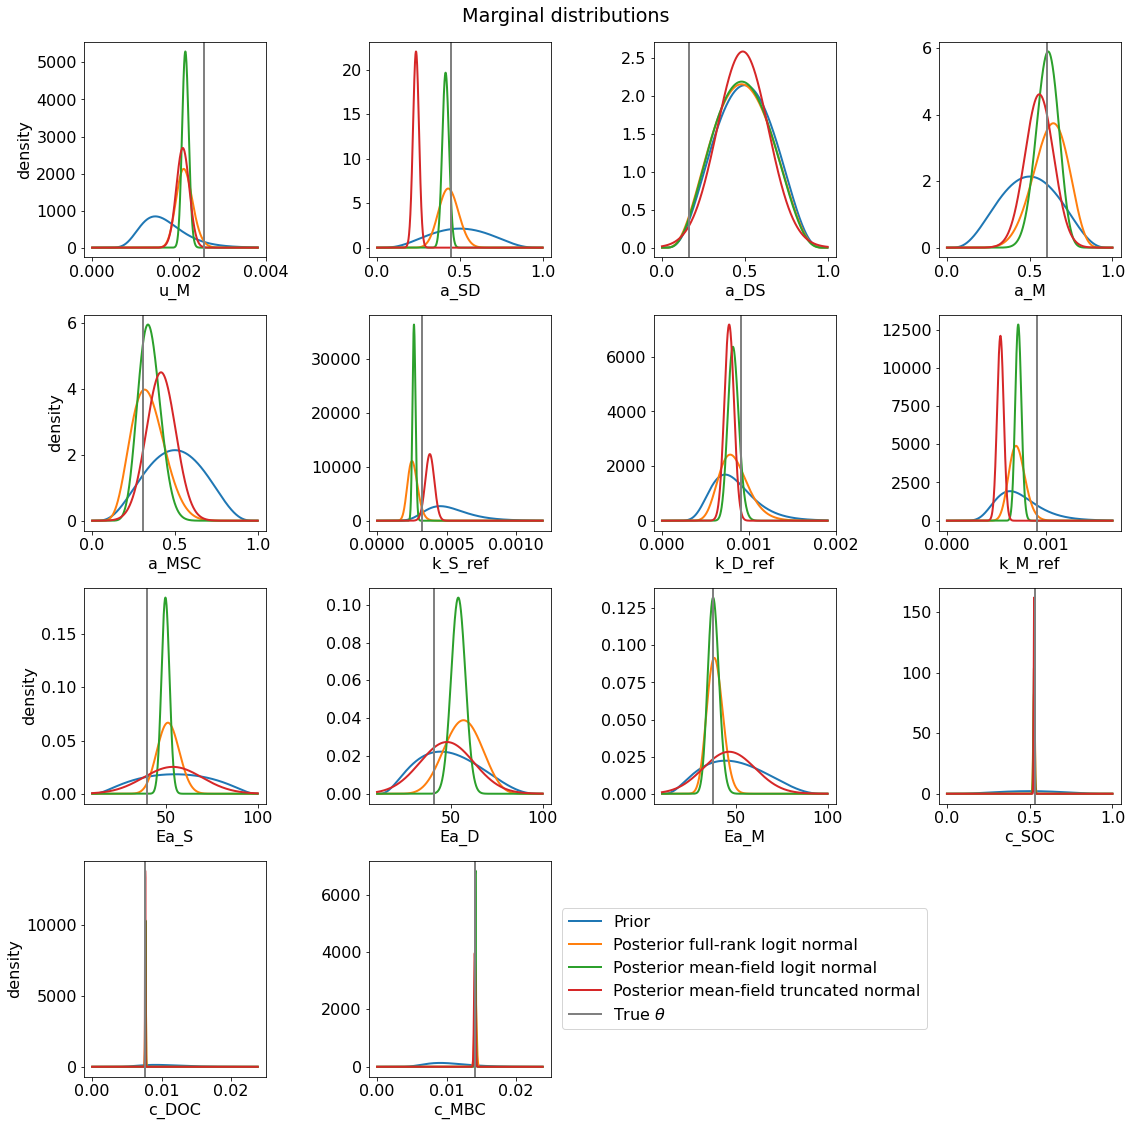

In [65]:
plot_theta(p_theta, [q_theta, q_theta_mf, q_theta_trunc_mf],
           theta_samples, labels, q_theta_raw.keys)

In [66]:
def plot_corr(q_theta_list, labels, param_names, num_samples=100000):
    plt.rcParams.update({'font.size': 12})
    
    # Calculate empirical correlation
    corr_list = []
    for q_theta in q_theta_list:
        assert isinstance(q_theta, MultivariateLogitNormal)
        samples = q_theta.sample((num_samples, )) # (N, D)
        corr_mc = np.corrcoef(samples.T)
        corr_list.append(corr_mc)
    
    # Plot
    num_cols = len(q_theta_list)
    fig, axes = plt.subplots(1, num_cols, figsize=(8*num_cols, 8))
    axes = np.atleast_1d(axes)
    D = len(q_theta_list[0].loc)
    
    for i, ax in enumerate(axes):
        plot = ax.imshow(corr_list[i], cmap='coolwarm', vmin=-1, vmax=1)
        ax.set_xticks(range(D))
        ax.set_xticklabels(param_names, rotation='vertical')
        ax.set_yticks(range(D))
        ax.set_yticklabels(param_names)
        ax.set_title(labels[i])
        
    plt.tight_layout()
    plt.colorbar(plot, ax=axes, shrink=0.8)
    plt.suptitle('Correlation between parameters')
    plt.show()

In [ ]:
plot_corr([q_theta_full, q_theta_mini5k, q_theta_mini1k],
          ['full', 'minibatch size = 5,000', 'minibatch size = 1,000'], priors.keys())

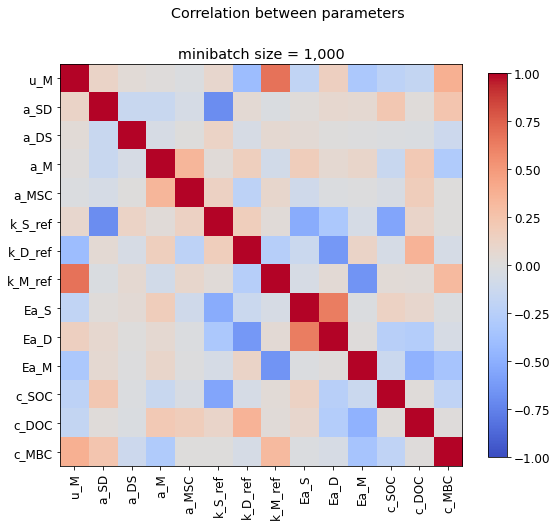

In [67]:
plot_corr([q_theta],
          ['minibatch size = 1,000'], q_theta_raw.keys)

In [68]:
def plot_x(x, t_span, n):
    num_sequences, time_steps, state_dim = x.shape
    fig, axes = plt.subplots(state_dim, figsize=(15, 15))
    step = (x.shape[1] - 1) // (n - 1)
    x_plot = x[:, ::step, :state_dim]
    #print(x.shape, x_plot.shape)
    
    labels = ['SOC', 'DOC', 'MBC', 'EEC']
    for i, ax in enumerate(axes):
        for j in range(num_sequences):
            ax.plot(t_span, x_plot[j, :, i])
        ax.set_ylabel(labels[i])

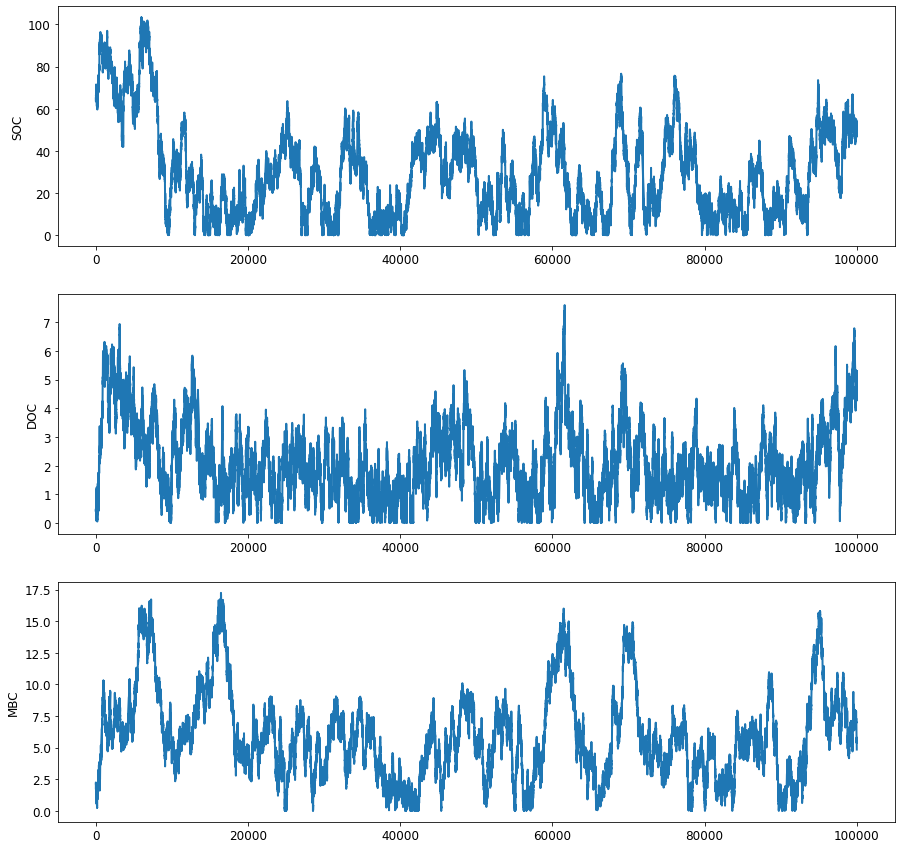

In [69]:
plot_x(x, t_span, n)

In [ ]:
hyperparams_file = 'data/dt_1_t_1000000_n_1_minibatch/theta_from_x_hyperparams_scon_c_{}.pt'.format(seed)
theta_file = 'data/dt_1_t_1000000_n_1_minibatch/theta_from_x_theta_scon_c_{}.pt'.format(seed)
x_file = 'data/dt_1_t_1000000_n_1_minibatch/theta_from_x_x_scon_c_{}.pt'.format(seed)
loss_file = 'data/dt_1_t_1000000_n_1_minibatch/theta_from_x_loss_scon_c_{}.pt'.format(seed)
q_file = 'data/dt_1_t_1000000_n_1_minibatch/theta_from_x_q_scon_c_{}.pt'.format(seed)
time_file = 'data/dt_1_t_1000000_n_1_minibatch/theta_from_x_time_scon_c_{}.pt'.format(seed)
torch.save(theta_hyperparams, hyperparams_file)
torch.save(theta_samples, theta_file)
torch.save(x, x_file)
torch.save([losses, losses_mf], loss_file)
torch.save([q_theta, q_theta_mf], q_file)
torch.save([times, times_mf], time_file)

In [63]:
save_str = 'data/dt_01_t_100000_minibatch_logit_theta_trunc_trans/SCON_C_{}.pt'
loss_file = save_str.format('loss_mini1k')
q_file = save_str.format('q_mini1k')
time_file = save_str.format('time_mini1k')
torch.save([losses, losses_mf, losses_trunc_mf], loss_file)
torch.save([q_theta, q_theta_mf, q_theta_trunc_mf], q_file)
torch.save([times, times_mf, times_trunc_mf], time_file)

#loss_file = 'data/dt_1_t_100000_n_1_minibatch/theta_from_multi_x_loss_mini5k_scon_c_{}.pt'.format(seed)
#q_file = 'data/dt_1_t_100000_n_1_minibatch/theta_from_multi_x_q_mini5k_scon_c_{}.pt'.format(seed)
#time_file = 'data/dt_1_t_100000_n_1_minibatch/theta_from_multi_x_time_mini5k_scon_c_{}.pt'.format(seed)
#torch.save([losses_mini5k, losses_mf_mini5k], loss_file)
#torch.save([q_theta_mini5k, q_theta_mf_mini5k], q_file)
#torch.save([times_mini5k, times_mf_mini5k], time_file)

In [ ]:
q_theta_full, q_theta_mf_full = torch.load('data/dt_1_t_100000_n_1_minibatch/theta_from_multi_x_q_full_scon_c_{}.pt'.format(seed))
losses_full, losses_mf_full = torch.load('data/dt_1_t_100000_n_1_minibatch/theta_from_multi_x_loss_full_scon_c_{}.pt'.format(seed))
times_full, times_mf_full = torch.load('data/dt_1_t_100000_n_1_minibatch/theta_from_multi_x_time_full_scon_c_{}.pt'.format(seed))


In [ ]:
q_theta_mini5k, q_theta_mf_mini5k = torch.load('data/dt_1_t_100000_n_1_minibatch/theta_from_multi_x_q_mini5k_scon_c_{}.pt'.format(seed))
losses_mini5k, losses_mf_mini5k = torch.load('data/dt_1_t_100000_n_1_minibatch/theta_from_multi_x_loss_mini5k_scon_c_{}.pt'.format(seed))
times_mini5k, times_mf_mini5k = torch.load('data/dt_1_t_100000_n_1_minibatch/theta_from_multi_x_time_mini5k_scon_c_{}.pt'.format(seed))

In [ ]:
q_theta_mini1k, q_theta_mf_mini1k = torch.load('data/dt_1_t_100000_n_1_minibatch/theta_from_multi_x_q_mini1k_scon_c_{}.pt'.format(seed))
losses_mini1k, losses_mf_mini1k = torch.load('data/dt_1_t_100000_n_1_minibatch/theta_from_multi_x_loss_mini1k_scon_c_{}.pt'.format(seed))
times_mini1k, times_mf_mini1k = torch.load('data/dt_1_t_100000_n_1_minibatch/theta_from_multi_x_time_mini1k_scon_c_{}.pt'.format(seed))

In [ ]:
q_theta, q_theta_mf = torch.load('data/dt_1_t_1000000_n_1_minibatch/theta_from_x_q_scon_c_{}.pt'.format(seed))
losses, losses_mf = torch.load('data/dt_1_t_1000000_n_1_minibatch/theta_from_x_loss_scon_c_{}.pt'.format(seed))
times, times_mf = torch.load('data/dt_1_t_1000000_n_1_minibatch/theta_from_x_time_scon_c_{}.pt'.format(seed))

## Compare with unobserved $x$

In [ ]:
q_theta_y_file = '../training_pt_outputs/q_theta_iter_310000_t_1000_dt_1.0_batch_40_layers_5_lr_0.0005_sd_scale_0.333_SCON-C_logit_multi_2021_09_22_11_48_46.pt'
q_theta_y_mf_file = '../training_pt_outputs/q_theta_iter_250000_t_1000_dt_1.0_batch_45_layers_5_lr_0.0005_sd_scale_0.333_SCON-C_no_CO2_logit_alt_2021_09_23_07_08_19.pt'
device=torch.device('cpu')
q_theta_y = extract_dist(torch.load(q_theta_y_file, map_location=device))
q_theta_y_mf = extract_dist(torch.load(q_theta_y_mf_file, map_location=device))

In [ ]:
theta_file = '../generated_data/SCON-C_CO2_logit_alt_sample_y_t_1000_dt_0-01_sd_scale_0-333_rsample.pt'
labels = ['full-rank, observe $y$', 'full-rank, observe $x$', 'mean-field, observe $y$', 'mean-field observe $x$']
plot_theta(p_theta, [q_theta_y, q_theta, q_theta_y_mf, q_theta_mf], theta_file, labels, q_theta_raw.keys,
           colors=[cm.tab10(1), cm.tab10(1), cm.tab10(2), cm.tab10(2)], linestyles=['-', '--', '-', '--'])

In [ ]:
plot_corr([q_theta_y, q_theta], ['Observe $y$', 'Observe $x$'], q_theta_raw.keys)

OMGGG I just realized `SBM_SDE` would need to change as well to support theta-from-multiple-x’s inference. We need to compute the negative ELBO:
$$\mathcal{L} = - \frac{1}{S} \sum_s \left[ \log p(\theta^{(s)}) + \log p(x|\theta^{(s)}) - \log q(\theta^{(s)}) \right]$$
where $S$ is the batch size.

With $M$ sequences of $x_i, i = 1, ..., M$, the log likelihood term is now:
$$\log p(x|\theta^{(s)}) = \sum_i \log p(x_i|\theta^{(s)})$$

So drift diffusion needs to take `C_PATH` of size `(S, M, N, D)` (currently `(S, N, D)`) and return a log likelihood tensor of size `(S, M)` (currently `(S, )`), where $N$ is the number of time steps and $D$ is the state dimensions.


In [ ]:
#(batch_size, 1, 1) 
diff1 = torch.arange(5).reshape((-1, 1, 1))
diff2 = torch.arange(5, 10).reshape((-1, 1, 1))
diff3 = torch.arange(10, 15).reshape((-1, 1, 1))
diff_list = [diff1, diff2, diff3]
diff_list

In [ ]:
tmp = 
tmp.shape

In [ ]:
diff_tensor = torch.diag_embed(torch.sqrt(LowerBound.apply(torch.cat(diff_list, 2), 1e-8))) # (batch_size, 1, state_dim, state_dim)
diff_tensor.shape

In [ ]:
diff_tensor[1] == torch.sqrt(torch.diag(torch.tensor([1, 6, 11])))

In [ ]:
(batch_size, N-1, state_dim)

In [ ]:
a = torch.randn(2, 3).reshape(2, 1, -1)
a.shape

In [ ]:
torch.diag_embed(a).shape

In [ ]:
a = torch.arange(12).reshape((2, 2, 3))
b = torch.arange(4).reshape((2, 2))

In [ ]:
a * b

In [ ]:
num_minibatches = 4

minibatch_size

In [ ]:
5000/3

In [ ]:
minibatch_size = n // 3
batch_indices = torch.arange(num_minibatches) * minibatch_size
batch_indices

In [ ]:
x.shape

In [ ]:
x0 = x[0]
x0.shape

In [ ]:
batch = torch.randint(num_minibatches, (niter, ))
batch

In [ ]:
[x_i[max(0, batch_indices[batch] - 1):batch_indices[batch + 1]] for x_i in x]

In [ ]:
x0[batch_indices[batch0]-1:batch_indices[batch0+1]].shape

In [ ]:
torch.gather(x, 0, )

In [ ]:
minibatch_size = 1000
t - minibatch_size

In [ ]:
start_indices = 

In [ ]:
start_indices[torch.randint(len(start_indices), (niter, ))]

In [ ]:
torch.all(torch.bincount(torch.randint(len(start_indices), (niter, ))) > 0)

In [ ]:
start_idx = torch.randint(100001, (niter, ))

In [ ]:
torch.bincount(start_idx)

In [ ]:
minibatch_indices = torch.arange(0, t + 1 - minibatch_size, 100) + 1

In [ ]:
minibatch_indices[-1]

In [ ]:
(torch.arange(0, t - minibatch_size, 100) + 1)[-1]

In [ ]:
s = {1, 2, 3}
l = []
l.extend(s)

In [ ]:
float('123.45')